# Exploration of Statevectors

I have created a set of functions in `explore_statevectors.py` that generate sparse and dense statevectors without the need to evolve the states.


In [1]:
from create_statevector import CreateStatevector

Right now, to create the statevectors we simply map a binary string to an index in the Statevector. The number of operation required to do this mapping is proportional to $O(rn)$ where $r$ is the number of objects (a.k.a. strings, a.k.a. patterns) in the database and $n$ is the number of bits required to represent an object.

Here is an example of a database with $r=2$ and $n=3$.

In [2]:
db = ['011', '111']

The indexes of non-zero elements in the statevector will be

In [3]:
non_zero_statevector_indexes = CreateStatevector.convert_db_to_statevector_indexes(db)
non_zero_statevector_indexes

[3, 7]

Note that the range of indexes for a statevector in this example is $[0, 7]$

The normalization factor in this case is simply based on the number of objects in the database:

In [4]:
CreateStatevector.get_normalization_factor(len(db))

0.7071067811865475

Once we have the vector of indexes for objects in our database (obtained using `convert_db_to_statevector_indexes`), we need to convert it to a statevector.

## Dense statevector
In the case of dense statevector representation (using QisKit's `Statevector` class) we will need $O(2^n)$ units of memory. Technically, we will also need $O(2^n)$ operations on the classical computer to construct this dense statevector.



In [5]:
qubits_count = len(db[0])
dense_statevector = CreateStatevector.create_dense_statevector(non_zero_statevector_indexes, qubits_count)
dense_statevector

Statevector([0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.70710678+0.j],
            dims=(2, 2, 2))


Note that the normalization factor is computed within `create_dense_statevector` -- no need to pass it explicitly.

Let us now construct the circuit.

In [6]:
from qiskit import QuantumCircuit
qc = QuantumCircuit(qubits_count)  # Create a quantum circuit with one qubit
qc.initialize(dense_statevector, qc.qubits)  # Initialize the circuit
print(qc)

     ┌──────────────────────────────────────────┐
q_0: ┤0                                         ├
     │                                          │
q_1: ┤1 Initialize(0,0,0,0.70711,0,0,0,0.70711) ├
     │                                          │
q_2: ┤2                                         ├
     └──────────────────────────────────────────┘


Let's verify the initialization using the simulator

In [7]:
from qiskit import Aer, execute
sim = Aer.get_backend('aer_simulator')
qc.save_statevector()  # Tell simulator to save statevector
result = execute(qc, sim).result()  # Do the simulation and return the result
out_state = result.get_statevector()
print(f"The output state vector is\n{out_state}")
out_counts = result.get_counts()
print(f"The output p-values are {out_counts}")

The output state vector is
Statevector([0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.70710678+0.j],
            dims=(2, 2, 2))
The output p-values are {'011': 0.5, '111': 0.5}


Dense statevector and the results of the simulator are correct.

### Transpile on a simulator
Let's transpile the circuit for a simulator.

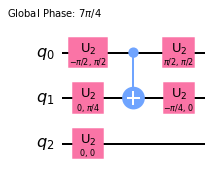

In [8]:
from qiskit.test.mock import FakeQasmSimulator
from qiskit.compiler import transpile
backend_architecture = FakeQasmSimulator()
cfg = backend_architecture.configuration()
qc = QuantumCircuit(qubits_count)  # Create a quantum circuit with one qubit
qc.initialize(dense_statevector, qc.qubits)  # Initialize the circuit
optimized_circuit = transpile(qc, coupling_map=cfg.coupling_map, basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=3)
optimized_circuit.draw(output='mpl')

And the summary of the gates in this circuit as follows:

In [9]:
optimized_circuit.count_ops()

OrderedDict([('u2', 5), ('cx', 1)])

### Transpile on a real device
Let's transpile the circuit for a real 5-qubit  and see the gates.

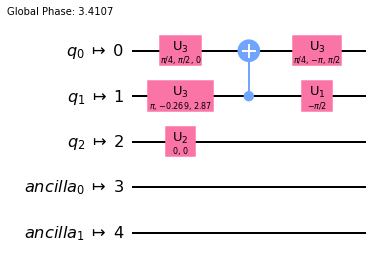

In [10]:
from qiskit.test.mock import FakeTenerife
from qiskit.compiler import transpile
backend_architecture = FakeTenerife()
cfg = backend_architecture.configuration()
qc = QuantumCircuit(qubits_count)  # Create a quantum circuit with one qubit
qc.initialize(dense_statevector, qc.qubits)  # Initialize the circuit
optimized_circuit = transpile(qc, coupling_map=cfg.coupling_map, basis_gates=cfg.basis_gates, optimization_level=3)
optimized_circuit.draw(output='mpl')

And the summary of the gates in this circuit as follows:

In [11]:
optimized_circuit.count_ops()

OrderedDict([('u3', 3), ('cx', 1), ('u1', 1), ('u2', 1)])

## Sparse statevector
Let us now look at the sparse statevector


If we leverage the sparse representation of the statevector (using QisKit's `SparseVectorStateFn` class) we will need only $O(r)$ units of memory. The computation time needed to construct the sparse vector is also $O(r)$.

In [12]:
sparse_statevector = CreateStatevector.create_sparse_statevector(non_zero_statevector_indexes, qubits_count)
print(sparse_statevector)

SparseVectorStateFn(  (0, 3)	0.7071067811865475
  (0, 7)	0.7071067811865475)


As we can see `sparse_statevector` captures only non-zero elements.

Existing QisKit code cannot directly call `qc.initialize(sparse_statevector, qc.qubits)`. However, I was able to alter the QisKit code to construct the circuit. The catch is at the end of the day it needs to convert the sparse representation to dense one, and we end up with the same operator `Initialize(0,0,0,0.70710678,0,0,0,0.70710678)`.

Then I went deeper trying to understand what this operator does. Technically it translates to QASM command
```python
initialize(0,0,0,0.70710678,0,0,0,0.70710678) q[0],q[1],q[2];
```

So now we need to understand what exactly `initialize` command does and if it really needs all the zeroes.

This took me to the [following](https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/circuits/3_summary_of_quantum_operations.ipynb) QisKit tutorial. If you look at line 85 of the tutorial (the section is titled "Further details"), it says that QisKit uses a method of [Shende et al.](https://arxiv.org/abs/quant-ph/0406176) The method boils down to factorization of the state vector (see the tutorial for details).

Unfortunately, I need to get back to prepping my undergrad courses. Thus, **Mushahid**, would be so kind as to take it further and create a concrete example of how the factorization works? We can probably start with the 2-qubit rather than 3-qubit system, to make the algebra easier. Given that most of our states will have $\alpha_\cdot = 0$, I suspect that the equations can be greatly simplified.